In [1]:
################## Explore IBCAO Bathymetry Data #################
# The purpose of this script is to explore the IBCAO 
# Bathymetry data in the region we are basing the idealized model 
# on to see how it looks and if we should alter our idealized
# bathymetry to be based on that.
#
# Notes:
# - 
#
###################################################################

In [2]:
# Load in the packages
#matplotlib widget 
import numpy as np
import datetime
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from matplotlib.path import Path
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import cmocean
import cartopy.crs as ccrs
import pandas as pd
import math
from scipy import interpolate
import sys
#import gridmap

In [3]:
# Load in the IBCAO data
ibcao_data = xr.open_dataset('/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/IBCAO_v4_1_200m.nc')

In [4]:
# Make a function to convert to lat/lon
# Make a function to do the conversion
def polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere):
    """Convert from Polar Stereographic (x, y) coordinates to
    geodetic longitude and latitude.

    Args:
        x (float): X coordinate(s) in km
        y (float): Y coordinate(s) in km
        true_scale_lat (float): true-scale latitude in degrees
        hemisphere (1 or -1): 1 for Northern hemisphere, -1 for Southern
        re (float): Earth radius in km
        e (float): Earth eccentricity

    Returns:
        If x and y are scalars then the result is a
        two-element list containing [longitude, latitude].
        If x and y are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.
    """

    e2 = e * e
    slat = true_scale_lat * np.pi / 180
    rho = np.sqrt(x ** 2 + y ** 2)

    if abs(true_scale_lat - 90.) < 1e-5:
        t = rho * np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e)) / (2 * re)
    else:
        cm = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        t = np.tan((np.pi / 4) - (slat / 2)) / \
            ((1 - e * np.sin(slat)) / (1 + e * np.sin(slat))) ** (e / 2)
        t = rho * t / (re * cm)

    chi = (np.pi / 2) - 2 * np.arctan(t)
    lat = chi + \
        ((e2 / 2) + (5 * e2 ** 2 / 24) + (e2 ** 3 / 12)) * np.sin(2 * chi) + \
        ((7 * e2 ** 2 / 48) + (29 * e2 ** 3 / 240)) * np.sin(4 * chi) + \
        (7 * e2 ** 3 / 120) * np.sin(6 * chi)
    lat = hemisphere * lat * 180 / np.pi
    lon = np.arctan2(hemisphere * x, -hemisphere * y)
    lon = hemisphere * lon * 180 / np.pi
    lon = lon + np.less(lon, 0) * 360
    return [lon, lat]

In [5]:
# Coordinates of rectangle in form of x min, x max, y min, and y max
# Each color corresponds to a different rectangle, comment out rectangles as needed 

# Red rectangle
x1, x2 = (-1.4e6), (-1.25e6) # x min, x max
y1, y2 = (1.73e6), (1.82e6) # y min, y max

# Green rectangle
x12, x22 = (-1.34e6), (-1.24e6) # x min, x max
y12, y22 = (1.7e6), (1.78e6) # y min, y max

# Purple rectangle, the OG grid
x13, x23 = (-1335773.817), (-1235773.817) # x min, x max
y13, y23 = (1690936.922), (1780936.922) #y min, y max

# Orange rectangle, the new grid
x14, x24 = (-1.340500e6), (-8.86e5) # x min, x max 
y14, y24 = (1.664e6), (1.7864e6) # y min, y max 

# Yellow rectangle
x15, x25 = (-1.35e6), (-1.24e6) # x min, x max
y15, y25 = (1.72e6), (1.78e6) # y min, y max

In [6]:
# # Plot this?
# # Create the map of the Arctic bathymetry and plot the rectangles on it
# # Create the figure
# fig1, ax1 = plt.subplots() #figsize = (15,10)

# # Set angle of grid rotation, rotating from the east
# angle_og = 25 # degrees
# angle2 = 22 # degrees

# # Create the rectangles, input in form (coordinates of bottom left corner, width, height)
# # Red
# #rect = patches.Rectangle((x1, y1), (x2-x1),(y2-y1), linewidth=3, edgecolor='r', 
#                          #facecolor='none')

# # Green
# #rect2 = patches.Rectangle((x12, y12), (x22-x12),(y22-y12), linewidth=3, edgecolor='g',
#                           #facecolor='none', angle=angle1)

# # Purple (OG grid)
# rect3 = patches.Rectangle((x13, y13), (x23-x13), (y23-y13), linewidth=3, edgecolor='purple', 
#                           facecolor='none', angle=angle_og)
# #rect3.set_hatch('x')

# # Orange (new larger whole-shelf grid, red for poster)
# rect4 = patches.Rectangle((x14, y14), (x24-x14), (y24-y14), linewidth=3, edgecolor='orange', 
#                           facecolor='none', angle=angle2)

# # Yellow
# #rect5 = patches.Rectangle((x15, y15), (x25-x15), (y25-y15), linewidth=3, edgecolor='yellow', 
#                           #facecolor='none', angle=angle1)
# # Get rid of land
# noland1 = np.ma.masked_where(z[:,:] > 0, z, copy=True)
# #noland1 = np.ma.masked_where(z_shallow[:,:] > 0, z_shallow, copy=True)

# # Determine spacing of contours
# lev = np.arange(0, 1000, 50)

# # (To add every 100th data point for sake of time, change :: to ::100)
# cs1 = ax1.contourf(x[::], y[::], noland1[::,::]*(-1), levels=lev, cmap=cmocean.cm.deep)

# # Plot contour of bathymetry lines
# #cs2 = ax1.contour(x[::], y[::], noland1[::,::]*(-1), colors='k', )
# #ax1.clabel(cs2, inline=True, fontsize=15)
 
# # Outline land
# ax1.contour(x, y, z, levels=[0], colors=('k',), linestyles=('-',),
#              linewidths=(0.5,))

# # Add grid boxes to map
# #ax1.add_patch(rect) #red
# #ax1.add_patch(rect2) #green
# #ax1.add_patch(rect3) #purple (OG)
# ax1.add_patch(rect4) #orange (new larger whole-shelf)
# #ax1.add_patch(rect5) #yellow
 
# # Add title
# ax1.set_title('The Desired Grid in the Arctic Ocean', fontsize=40, y=1.08)
 
# # Format axes
# ax1.set_xlabel('x (meters)', fontsize=30)
# ax1.set_ylabel('y (meters)', fontsize=30)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# #plt.grid(True)
 
# # Specify colorbar
# cbar1 = fig1.colorbar(cs1)
# cbar1.set_label(label='Depth (meters)', size=30)
# cbar1.ax.invert_yaxis()
# cbar1.ax.tick_params(labelsize=20) 

# plt.show()


In [7]:
# # Try to plot a trimmed version of this region

# fig, ax = plt.subplots(figsize=(20,20))

# # Plot the data
# #ibcao_data.z.plot()

In [8]:
# Purple rectangle, the OG grid
x13, x23 = (-1335773.817), (-1235773.817) # x min, x max
y13, y23 = (1690936.922), (1780936.922) #y min, y max

# Orange rectangle, the new grid
x14, x24 = (-1.340500e6), (-8.86e5) # x min, x max 
y14, y24 = (1.664e6), (1.7864e6) # y min, y max 

min_x_shelfbreak, max_x_shelfbreak = (-1.340500e6), (-8.30e5)
min_y_shelfbreak, max_y_shelfbreak = (1.687e6), (1.7879e6)

# Make a wider region since we are focues on shelfbreka jet beyond our domain 

ibcao_data_trimmed = ibcao_data.sel(x=slice(min_x_shelfbreak, max_x_shelfbreak), y=slice(min_y_shelfbreak, max_y_shelfbreak))


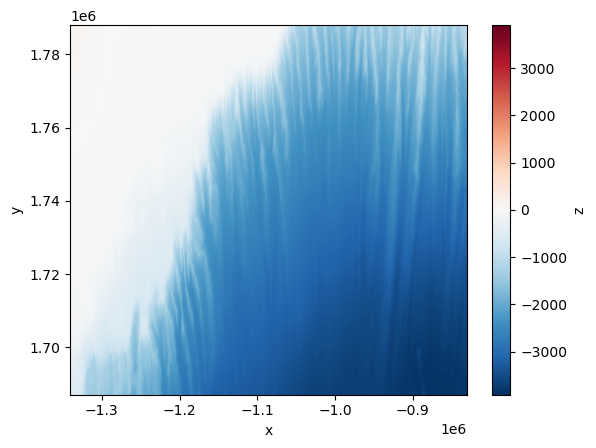

In [9]:
# Plot this trimmed data

#ibcao_data_trimmed = ibcao_data.sel(x=slice(x14, x24), y=slice(y14, y24))

ibcao_data_trimmed.z.plot()

In [10]:
# Convert data x,y to lon, lat
# Trimmed region
lon_x_360, lat_y = polar_xy_to_lonlat(ibcao_data_trimmed.x, ibcao_data_trimmed.y, 90, 6378137.0, 0.08181919, 1) #lon in (0 to 360) convention
lon_x = (lon_x_360 + 180) % 360 - 180 #lon in (-180 to 180) convention

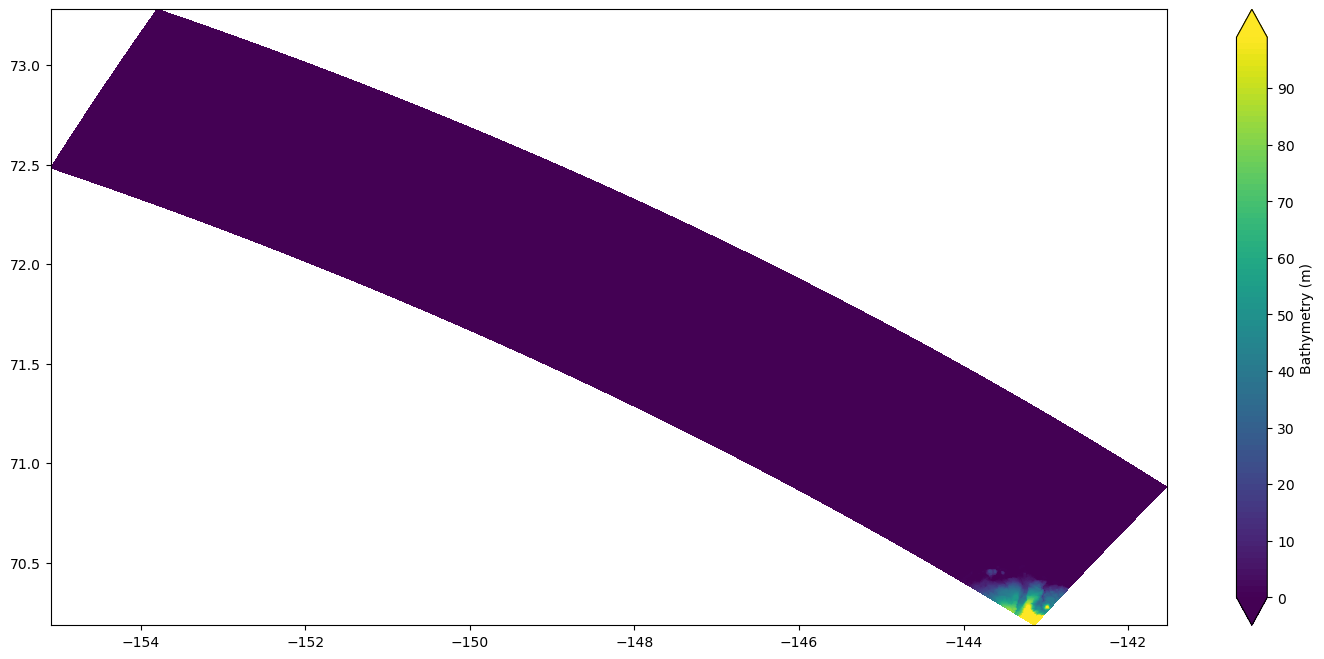

In [11]:
# Then plot
# Plot the bathymetry data in lat/lon

lev_bathy = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize=(18,8))

cs1 = ax.contourf(lon_x, lat_y, ibcao_data_trimmed.z.transpose(), levels=lev_bathy, extend='both')

fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [12]:
# Then try changing all to lat/lon and trimming

In [13]:
# Once we get the data to the region, convert to lat/lon


In [14]:
# Convert data x,y to lon, lat
# All data
lon_x_360_all, lat_y_all = polar_xy_to_lonlat(ibcao_data.x, ibcao_data.y, 90, 6378137.0, 0.08181919, 1) #lon in (0 to 360) convention
lon_x_all = (lon_x_360_all + 180) % 360 - 180 #lon in (-180 to 180) convention

In [15]:
ibcao_data.z

<xarray.DataArray 'z' (y: 29100, x: 29100)> Size: 3GB
[846810000 values with dtype=float32]
Coordinates:
  * x        (x) float64 233kB -2.91e+06 -2.91e+06 ... 2.91e+06 2.91e+06
  * y        (y) float64 233kB -2.91e+06 -2.91e+06 ... 2.91e+06 2.91e+06
Attributes:
    long_name:     z
    actual_range:  [-5561.61083984  6142.61376953]

In [16]:
lat_y_all

<xarray.DataArray (x: 29100, y: 29100)> Size: 7GB
array([[54.31028329, 54.31143461, 54.3125859 , ..., 54.3125859 ,
        54.31143461, 54.31028329],
       [54.31143461, 54.31258598, 54.31373732, ..., 54.31373732,
        54.31258598, 54.31143461],
       [54.3125859 , 54.31373732, 54.3148887 , ..., 54.3148887 ,
        54.31373732, 54.3125859 ],
       ...,
       [54.3125859 , 54.31373732, 54.3148887 , ..., 54.3148887 ,
        54.31373732, 54.3125859 ],
       [54.31143461, 54.31258598, 54.31373732, ..., 54.31373732,
        54.31258598, 54.31143461],
       [54.31028329, 54.31143461, 54.3125859 , ..., 54.3125859 ,
        54.31143461, 54.31028329]])
Coordinates:
  * x        (x) float64 233kB -2.91e+06 -2.91e+06 ... 2.91e+06 2.91e+06
  * y        (y) float64 233kB -2.91e+06 -2.91e+06 ... 2.91e+06 2.91e+06

In [17]:
# Add in lat/lon as coordinates
ibcao_data = ibcao_data.assign_coords(
    lat=(('x','y'), lat_y_all.values),
    lon=(('x','y'), lon_x_all.values)
)

# Set these as the coordinates
ibcao_data =ibcao_data.set_coords(['lat', 'lon'])

In [18]:
# Now try subsetting this
lat_min, lat_max = 71.25, 71.8
lon_min, lon_max = -153, -150

mask = (
    (ibcao_data.lat >= lat_min) & (ibcao_data.lat <= lat_max) &
    (ibcao_data.lon >= lon_min) & (ibcao_data.lon <= lon_max)
)

ibcao_data_reg1 = ibcao_data.where(mask, drop=True)

In [27]:
# Mask out land 

#ibcao_data['z_noland'] = np.ma.masked_where(ibcao_data.z[:,:] > 0, ibcao_data.z, copy=True)

ibcao_data['z_noland'] = ibcao_data.z.where(ibcao_data.z <= 0)


In [25]:
ibcao_data.z.dims

('y', 'x')

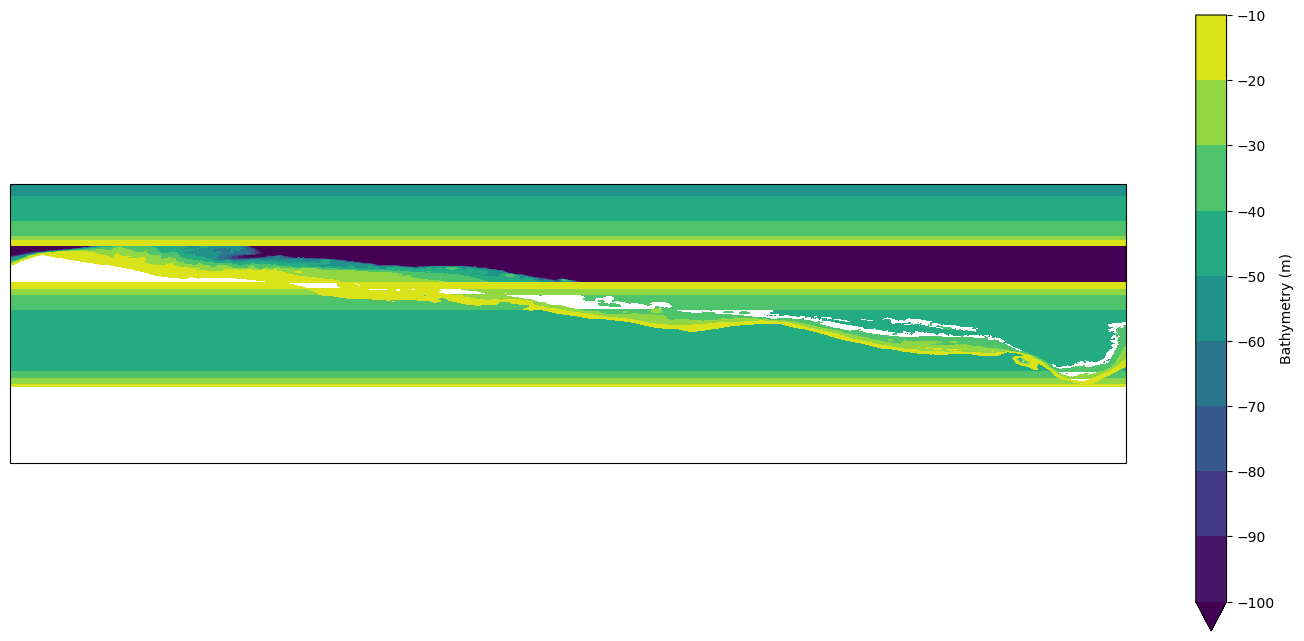

In [29]:
# Plot the data

# Set the bathymetry levels
lev_bathy = np.arange(-100, 0, 10)

# Make the figure
fig, ax = plt.subplots(figsize=(18,8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the bathymetry data
cs1 = ax.contourf(ibcao_data.lon, ibcao_data.lat, ibcao_data.z_noland.transpose(), levels=lev_bathy, extend='min', transform=ccrs.PlateCarree())

# Set the map extent
ax.set_extent([-157, -137, 68, 73], ccrs.PlateCarree())

# Add a colorbar 
fig.colorbar(cs1, extend='min').set_label('Bathymetry (m)')

In [ ]:
# So now that we have the data with lat/lon, 
# trim to this region and plot it, then 
# plot the alongshore mean to see how this looks

In [30]:
# Try to trim the data to the box
ibcao_data_trimmed_latlon = ibcao_data.sel(lon=slice(-153,150),lat=slice(71,71.8))

KeyError: "no index found for coordinate 'lon'"

In [ ]:
# Plot this
# Plot the data

# Set the bathymetry levels
lev_bathy = np.arange(-1000, 0, 10)

# Make the figure
fig, ax = plt.subplots(figsize=(18,8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the bathymetry data
cs1 = ax.contourf(ibcao_data_trimmed_latlon.lon, ibcao_data_trimmed_latlon.lat, ibcao_data_trimmed_latlon.z.transpose(), levels=lev_bathy, extend='both', transform=ccrs.PlateCarree())

# Set the map extent
ax.set_extent([-157, -137, 68, 73], ccrs.PlateCarree())

# Add a colorbar 
fig.colorbar(cs1, extend='both').set_label('Bathymetry (m)')

In [ ]:
# Then use that to trim to our box and plot it

In [ ]:
# Then take the alongshore mean of this box spanning from coast to ~71.8 N 

In [ ]:
# Then plot this to see how it looks
